## Tutorial: Tokenization and Transformer Model

#### Objective
- Understand tokenization and how it prepares text data for transformers.
- Explore how transformers process tokenized input using attention mechanisms and visualize attention weights to observe how transformers focus on specific tokens.
- Examine the inference process in GPT models, highlighting techniques that optimize performance.

#### Prerequisites
- Python installed (3.8+ recommended).
- Install necessary libraries:

In [1]:
%pip install transformers torch matplotlib seaborn
%pip install protobuf==3.20.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Step 1: Tokenization Basics

Tokenization is the process of breaking down text into smaller units (tokens) that a model can understand. Subword tokenization (e.g., Byte-Pair Encoding) is commonly used in transformers.

**Pre-trained Tokenizer **

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import AutoTokenizer

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Sample text
text = "Transformers have revolutionized natural language processing!"

# Tokenize the input
tokens = tokenizer.tokenize(text)
input_ids = tokenizer(text, return_tensors="pt")["input_ids"]

print("Original Text:", text)
print("Tokens:", tokens)
print("Input IDs:", input_ids)

Original Text: Transformers have revolutionized natural language processing!
Tokens: ['transformers', 'have', 'revolution', '##ized', 'natural', 'language', 'processing', '!']
Input IDs: tensor([[  101, 19081,  2031,  4329,  3550,  3019,  2653,  6364,   999,   102]])


In [3]:
# Trained tokenizers
# from tokenizers import Tokenizer, models, trainers

# # Initialize a new BPE tokenizer
# tokenizer = Tokenizer(models.BPE())
# tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# # Train the tokenizer on custom data
# trainer = trainers.BpeTrainer(vocab_size=50_000)
# tokenizer.train_from_iterator(["Hello, how are you?", "I am fine, thank you!"], trainer)

# # Example usage
# input_text = "Hello, how are you?"
# tokens = tokenizer.encode(input_text)
# print(tokens.tokens())  # Outputs tokens based on trained vocabulary


#### Step 2: Understanding Transformers
**Transformer Architecture**

Transformers process tokenized inputs through layers of self-attention and feed-forward networks, generating contextualized embeddings for each token.

In [4]:
from transformers import AutoModel

# Load a pre-trained transformer model
model = AutoModel.from_pretrained("bert-base-uncased")

# Pass the tokenized input to the model
outputs = model(input_ids)

# Extract the hidden states
hidden_states = outputs.last_hidden_state
print("Shape of Hidden States:", hidden_states.shape)

Shape of Hidden States: torch.Size([1, 10, 768])


** Explanation: **
- `hidden_states` contains contextual embeddings for each token.
- The shape is `[batch_size, sequence_length, hidden_size]`.

#### Step 3: Visualizing Attention Weights
**What Are Attention Weights?**

Attention weights determine how much importance the model assigns to each token when processing a given token.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


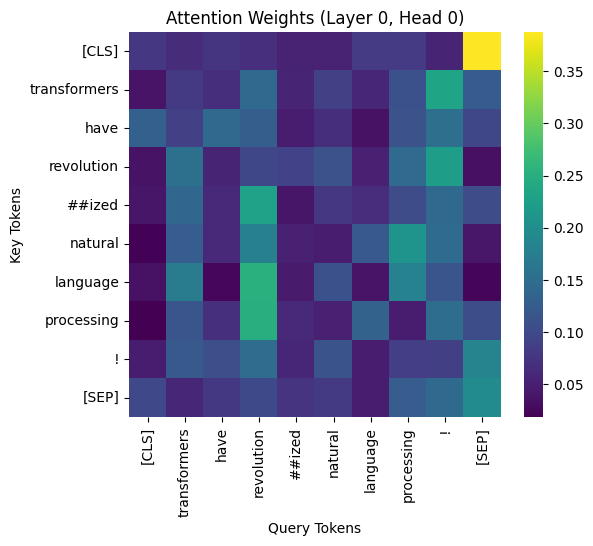

In [5]:
from transformers import BertModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model with attention outputs enabled
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

# Sample text
text = "Transformers have revolutionized natural language processing!"

# Tokenize the input
tokens = tokenizer.tokenize(text)
input_ids = tokenizer(text, return_tensors="pt")["input_ids"]

# Forward pass to extract attention weights
outputs = model(input_ids)
attention_weights = outputs.attentions  # List of attention matrices (one per layer)

# Select attention weights from the first layer and the first head
layer = 0  # First layer
head = 0   # First attention head
attention_matrix = attention_weights[layer][0, head].detach().numpy()

# Visualize the attention matrix
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
plt.figure(figsize=(6, 5))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Weights (Layer 0, Head 0)")
plt.xlabel("Query Tokens")
plt.ylabel("Key Tokens")
plt.show()

#### Step 4: Auto-Regressive Decoding

- Generate text and visualize probabilities with autoregressive decoding

In [18]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

import torch

# Generate text auto-regressively
input_text = "The winter in California is "
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate top-k sequences
top_k = 5
output_sequences = model.generate(
    input_ids,
    max_length=20,
    num_return_sequences=top_k,
    num_beams=top_k,
    early_stopping=True,
    do_sample=True,
    top_k=50
)

# Decode and print the top-k sequences
print("Top-k decoded sequences:")
for i, seq in enumerate(output_sequences):
    decoded_seq = tokenizer.decode(seq, skip_special_tokens=True)
    print(f"{i + 1}: {decoded_seq}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-k decoded sequences:
1: The winter in California is iced. It's hot. It's cold. It's cold.
2: The winter in California is iced up, and it's going to be colder than it used to
3: The winter in California is iced and cold, and there is no water to drink.


4: The winter in California is iced, and it's hard to find a place that doesn't have
5: The winter in California is iced, and it's cold enough that I can't stand it.


Autoregressive deocoding vs speculative decoding

In [9]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessorList, TopPLogitsWarper
# from sampling_units import speculative_generate, autoregressive_generate
# import time

# # Load the target (large) and drafter (small) models
# target_model_name = "gpt2-large"
# drafter_model_name = "distilgpt2"

# tokenizer = AutoTokenizer.from_pretrained(target_model_name)
# target_model = AutoModelForCausalLM.from_pretrained(target_model_name)
# drafter_model = AutoModelForCausalLM.from_pretrained(drafter_model_name)

# # Define parameters for generation
# gen_len = 10  # Maximum number of tokens to generate
# gamma = 8  # Number of drafts generated by the drafter model at each step
# logits_processor = LogitsProcessorList([
#     TopPLogitsWarper(top_p=0.9)
# ])

# # Input prompt
# input_text = "The winter in California is"
# input_ids = tokenizer.encode(input_text, return_tensors='pt')

# # ----------------------------
# # 🔸 Time: Auto-regressive decoding
# # ----------------------------
# start_time_ar = time.time()

# output_ids_ar = autoregressive_generate(
#     input_ids,
#     target_model,
#     logits_processor=logits_processor,
#     max_gen_len=gen_len,
#     end_tokens_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# end_time_ar = time.time()
# elapsed_time_ar = end_time_ar - start_time_ar
# output_ar = tokenizer.decode(output_ids_ar[0], skip_special_tokens=True)

# # ----------------------------
# # 🔸 Time: Speculative decoding
# # ----------------------------
# start_time_sd = time.time()

# output_ids_sd, alpha = speculative_generate(
#     input_ids,
#     drafter_model,
#     target_model,
#     logits_processor=logits_processor,
#     gamma=gamma,
#     max_gen_len=gen_len,
#     end_tokens_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# end_time_sd = time.time()
# elapsed_time_sd = end_time_sd - start_time_sd
# output_sd = tokenizer.decode(output_ids_sd[0], skip_special_tokens=True)

# # ----------------------------
# # ✅ Display Results
# # ----------------------------
# print("\n======================")
# print("📜 Auto-Regressive Output:\n", output_ar)
# print(f"🕒 Time (AR decoding): {elapsed_time_ar:.2f} seconds")
# print("\n======================")
# print("⚡ Speculative Decoding Output:\n", output_sd)
# print(f"🕒 Time (Speculative decoding): {elapsed_time_sd:.2f} seconds")
# print(f"⚡ Speedup: {elapsed_time_ar / elapsed_time_sd:.2f}x")



📜 Auto-Regressive Output:
 The winter in California is a time of year when the temperature drops to the
🕒 Time (AR decoding): 2.79 seconds

⚡ Speculative Decoding Output:
 The winter in California is a time of year when the temperature drops to the
🕒 Time (Speculative decoding): 3.02 seconds
⚡ Speedup: 0.92x
